<a href="https://colab.research.google.com/github/jiku100/2020-2-machine-running-proejct/blob/master/assignment10/%EC%8B%A0%EC%84%9D%EA%B2%BD_assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification for Multiple Categories using Pytorch for best accuracy**



# 1. Import library
<hr>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# 2. Preprocessing Data
<hr>

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

In [17]:
data_path = './MNIST'

data_test   = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
data_train  = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw





Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


type of one image <class 'torch.Tensor'>
size of one image :  torch.Size([1, 28, 28])
type of label :  <class 'int'>
label :  7
255


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


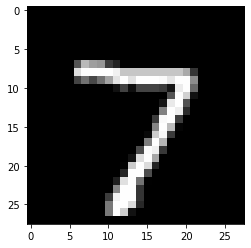

In [18]:
one_image, label = data_train[0]
print("type of one image", type(one_image))
print("size of one image : ", one_image.shape)
plt.imshow(one_image.squeeze().numpy(), cmap='gray')
print("type of label : ", type(label))
print("label : ", label)
print(np.max(data_train.train_data[0].view(-1).numpy()))

In [34]:
learning_rate = 0.001
training_epochs = 100
batch_size = 32
drop_prob = 0.3

In [35]:
train_loader = DataLoader(dataset = data_train, batch_size = batch, shuffle = True) ## batch size 32 짜리 train loader 생성
test_loader = DataLoader(dataset = data_test, batch_size = batch, shuffle = True) ## batch size 32 짜리 test loader 생성

# 3. Define Model
<hr>

In [36]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20, bias = True),
            nn.ReLU(),
            nn.Dropout(p=drop_prob)
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=64, bias = True),
            nn.ReLU(),
            nn.Dropout(p=drop_prob)
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=64, out_features=10, bias = True),
            nn.LogSoftmax(dim=1),
        ) 

    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out



In [37]:
model = classification().to(device)

In [38]:
criterion = nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 4. Training
<hr>

In [39]:
total_batch= len(train_loader)

In [40]:
print(total_batch)

313


In [41]:
def accuracy(log_pred, y_true):
    y_pred = torch.argmax(log_pred, dim=1)
    return (y_pred == y_true).to(torch.float).mean()

In [42]:
def training(model, loss, optim, training_epochs, train_loader, test_loader):
  L_iters_train = []
  accuracy_train = []
  L_iters_test = []
  accuracy_test = []
  for epoch in range(training_epochs):
    total_cost_train = 0
    total_cost_test = 0
    total_acc_train = 0
    total_acc_test = 0
    model.train()
    for X, Y in train_loader:
      X = X.to(device)
      Y = Y.to(device)

      optim.zero_grad()
      train_pred = model(X)
      cost = loss(train_pred, Y)
      cost.backward()
      optim.step()
      total_cost_train += cost
      total_acc_train += accuracy(train_pred, Y)
      
    avg_cost_train = total_cost_train / len(train_loader)
    avg_acc_train = total_acc_train / len(train_loader)

    L_iters_train.append(avg_cost_train)
    accuracy_train.append(avg_acc_train)
    model.eval()
    with torch.no_grad():
      for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        test_pred = model(X_test)
        cost_test = loss(test_pred, Y_test)
        total_cost_test += cost_test
        total_acc_test += accuracy(test_pred, Y_test)
      avg_cost_test = total_cost_test / len(test_loader)
      avg_acc_test = total_acc_test / len(test_loader)
    
      accuracy_test.append(avg_acc_test)
      L_iters_test.append(avg_cost_test)

    print("Epoch: %02d Training Loss: %.9f Testing Loss: %.9f  Training Acc: %.9f Testing Acc: %.9f" %((epoch + 1),avg_cost_train, avg_cost_test, avg_acc_train, avg_acc_test))
  return L_iters_train, accuracy_train, L_iters_test, accuracy_test

In [43]:
L_train, A_train, L_test, A_test = training(model, criterion, optimizer, training_epochs, train_loader, test_loader)

Epoch: 01 Training Loss: 0.814707041 Testing Loss: 0.443375617  Training Acc: 0.738318682 Testing Acc: 0.866116703
Epoch: 02 Training Loss: 0.415672809 Testing Loss: 0.379977584  Training Acc: 0.872903347 Testing Acc: 0.878833354
Epoch: 03 Training Loss: 0.336174577 Testing Loss: 0.270712763  Training Acc: 0.898562312 Testing Acc: 0.919616699
Epoch: 04 Training Loss: 0.282525539 Testing Loss: 0.244691521  Training Acc: 0.912539899 Testing Acc: 0.926166654
Epoch: 05 Training Loss: 0.247300476 Testing Loss: 0.243293673  Training Acc: 0.923023164 Testing Acc: 0.928083360
Epoch: 06 Training Loss: 0.230170548 Testing Loss: 0.252179652  Training Acc: 0.929013550 Testing Acc: 0.925633371
Epoch: 07 Training Loss: 0.208969131 Testing Loss: 0.228791475  Training Acc: 0.933606207 Testing Acc: 0.930283368
Epoch: 08 Training Loss: 0.196169481 Testing Loss: 0.260337621  Training Acc: 0.938099027 Testing Acc: 0.926950037
Epoch: 09 Training Loss: 0.184936941 Testing Loss: 0.199572176  Training Acc: 0.

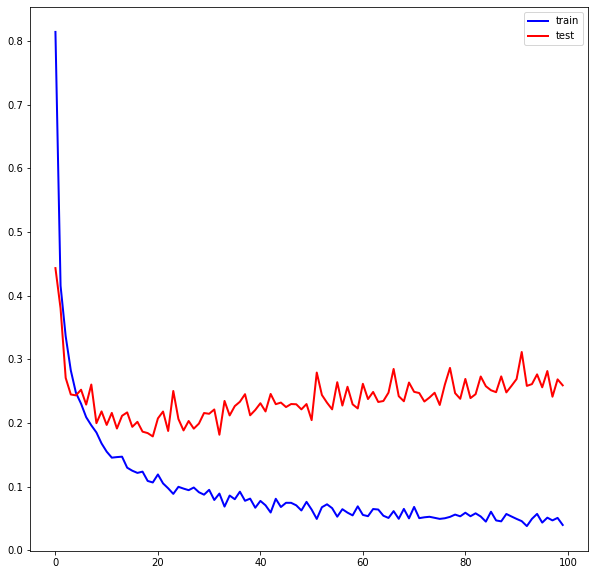

In [44]:
plt.figure(figsize = (10,10))
plt.plot(L_train, linewidth = 2, c='b', label = "train")
plt.plot(L_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

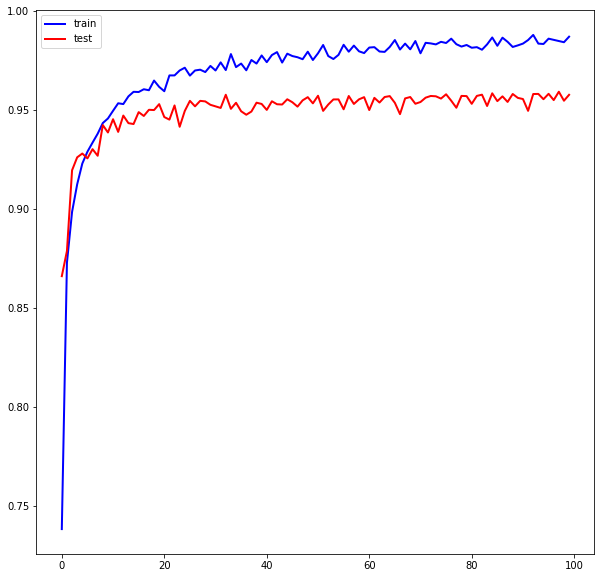

In [45]:
plt.figure(figsize = (10,10))
plt.plot(A_train, linewidth = 2, c='b', label = "train")
plt.plot(A_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

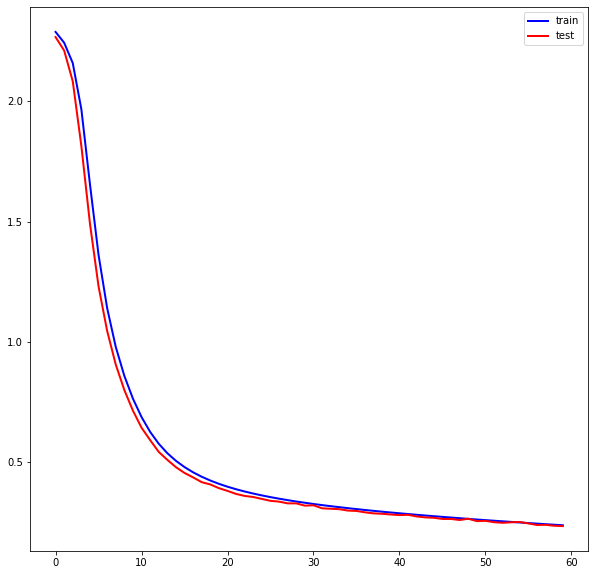

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(L_train_128, linewidth = 2, c='b', label = "train")
plt.plot(L_test_128, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

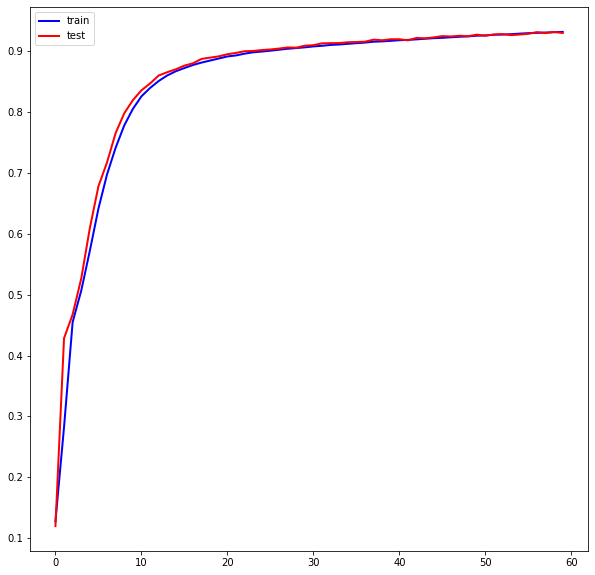

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(A_train_128, linewidth = 2, c='b', label = "train")
plt.plot(A_test_128, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

# 5. Output
<hr>

## 1. Plot the training and testing losses with a batch size of 32

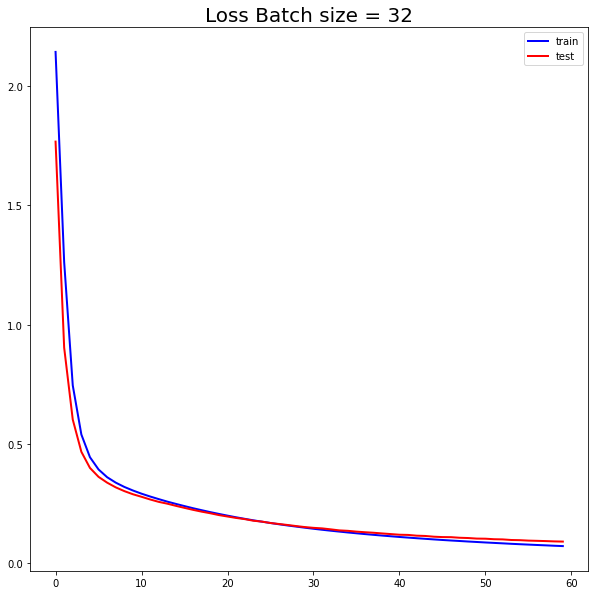

In [ ]:
plt.figure(figsize = (10,10))
plt.title("Loss Batch size = 32", fontsize = 20)
plt.plot(L_train_32, linewidth = 2, c='b', label = "train")
plt.plot(L_test_32, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

## 2. Plot the training and testing accuracies with a batch size of 32

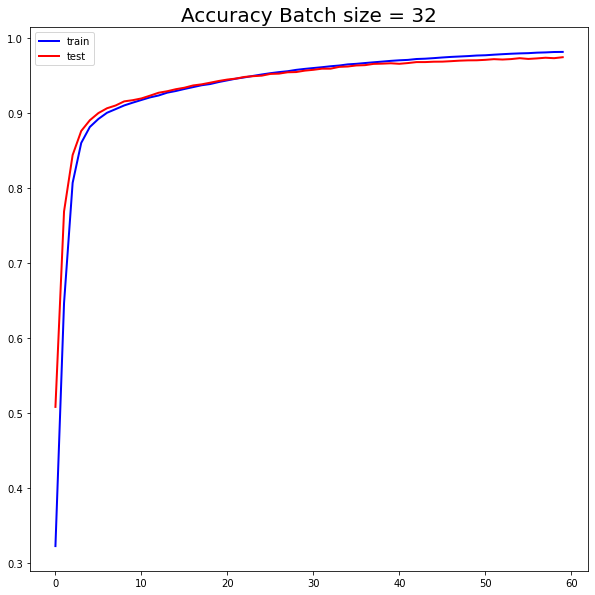

In [ ]:
plt.figure(figsize = (10,10))
plt.title("Accuracy Batch size = 32", fontsize = 20)
plt.plot(A_train_32, linewidth = 2, c='b', label = "train")
plt.plot(A_test_32, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

## 3. Plot the training and testing losses with a batch size of 64

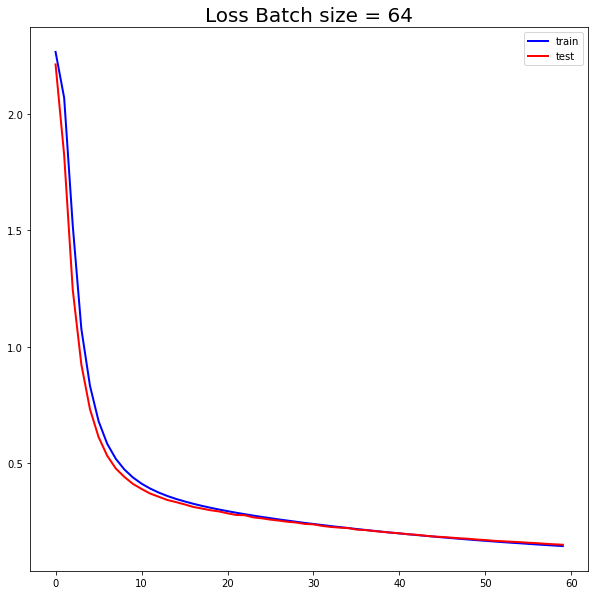

In [ ]:
plt.figure(figsize = (10,10))
plt.title("Loss Batch size = 64", fontsize = 20)
plt.plot(L_train_64, linewidth = 2, c='b', label = "train")
plt.plot(L_test_64, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

## 4. Plot the training and testing accuracies with a batch size of 64

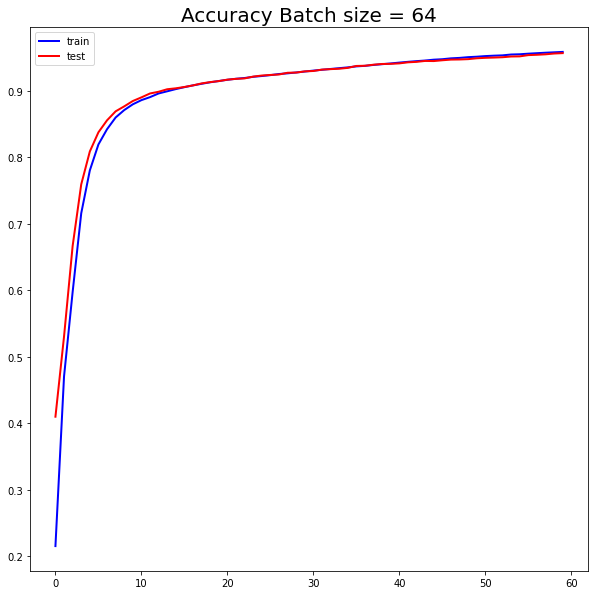

In [ ]:
plt.figure(figsize = (10,10))
plt.title("Accuracy Batch size = 64", fontsize = 20)
plt.plot(A_train_64, linewidth = 2, c='b', label = "train")
plt.plot(A_test_64, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

## 5. Plot the training and testing losses with a batch size of 128

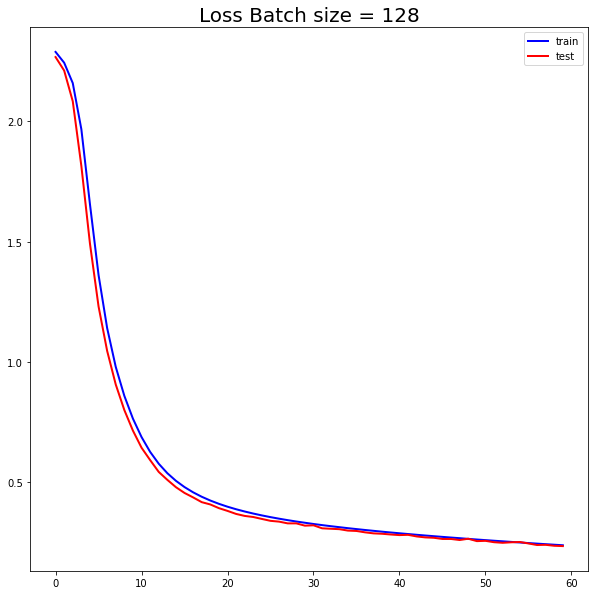

In [ ]:
plt.figure(figsize = (10,10))
plt.title("Loss Batch size = 128", fontsize = 20)
plt.plot(L_train_128, linewidth = 2, c='b', label = "train")
plt.plot(L_test_128, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

## 6. Plot the training and testing accuracies with a batch size of 128

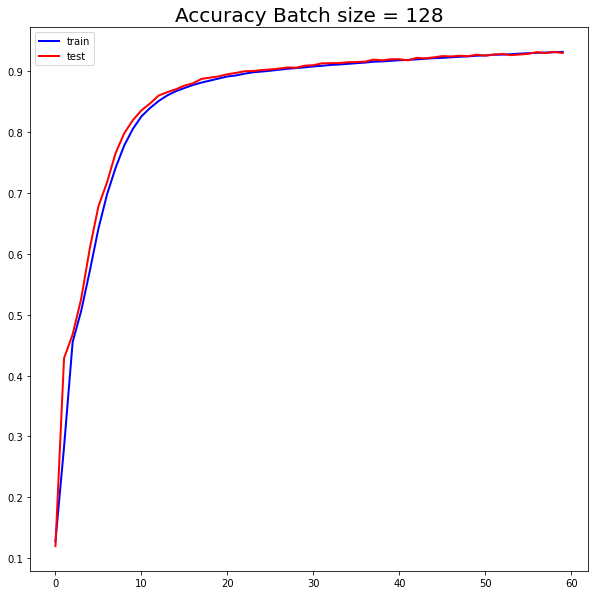

In [ ]:
plt.figure(figsize = (10,10))
plt.title("Accuracy Batch size = 128", fontsize = 20)
plt.plot(A_train_128, linewidth = 2, c='b', label = "train")
plt.plot(A_test_128, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

## 7. Print the loss at convergence with different mini-batch sizes

In [ ]:
print("mini-batch size   32    64    128")
print("training loss    %.2f  %.2f   %.2f" %(L_train_32[-1], L_train_64[-1], L_train_128[-1]))
print("testing loss     %.2f  %.2f   %.2f" %(L_test_32[-1], L_test_64[-1], L_test_128[-1]))

mini-batch size   32    64    128
training loss    0.07  0.15   0.24
testing loss     0.09  0.15   0.23


## 8. Print the accuracy at convergence with different mini-batch sizes

In [ ]:
print("mini-batch size   32    64    128")
print("training loss    %.2f  %.2f   %.2f" %(A_train_32[-1], A_train_64[-1], A_train_128[-1]))
print("testing loss     %.2f  %.2f   %.2f" %(A_test_32[-1], A_test_64[-1], A_test_128[-1]))

mini-batch size   32    64    128
training loss    0.98  0.96   0.93
testing loss     0.97  0.96   0.93
